# Quantization-aware training VGG16

Quantization-aware model training ensures that the forward pass matches precision for both training and inference.The quantization error is modeled using fake quantization nodes to simulate the effect of quantization in the forward and backward passes. The forward-pass models quantization, while the backward-pass models quantization as a straight-through estimator. Both the forward- and backward-pass simulate the quantization of weights and activations. Note that during back propagation, the parameters are updated at high precision as this is needed to ensure sufficient precision in accumulating tiny adjustments to the parameters.

**Model quantization**

Quantizing deep neural networks uses techniques that allow for reduced precision representations of weights and, optionally, activations for both storage and computation. Quantization provides several benefits:

    - Support on existing CPU platforms.
    - Quantization of activations reduces memory access costs for reading and storing intermediate activations.
    - Many CPU and hardware accelerator implementations provide SIMD instruction capabilities, which are especially beneficial for quantization.


In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

1.14.0


Using TensorFlow backend.


In [ ]:
!mkdir checkpoints

In [2]:
def get_train_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_train_for_keras = original_data.loc[original_data['is_valid'] == False, ['relative_path', 'label']]
    df_train_for_keras = df_train_for_keras.astype(str)
    return df_train_for_keras

def get_val_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_val_for_keras = original_data.loc[original_data['is_valid'] == True, ['relative_path', 'label']]
    df_val_for_keras = df_val_for_keras.astype(str)
    return df_val_for_keras

def get_test_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_test_for_keras = original_data[['relative_path', 'label']]
    df_test_for_keras = df_test_for_keras.astype(str)
    return df_test_for_keras

df_train_for_keras = get_train_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(len(df_train_for_keras))

df_val_for_keras = get_val_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_val_for_keras[:5])

df_test_for_keras = get_test_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "test_group.csv")
print(len(df_val_for_keras)+len(df_train_for_keras)+len(df_test_for_keras))

directory = str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage"

38070
                                           relative_path label
38070   Pepper,_bell___Bacterial_spot/JR_B.Spot 3293.JPG    18
38071        Squash___Powdery_mildew/UMD_Powd.M 0707.JPG    25
38072              Apple___Apple_scab/FREC_Scab 3120.JPG     0
38073               Grape___Black_rot/FAM_B.Rot 3107.JPG    11
38074  Tomato___Tomato_Yellow_Leaf_Curl_Virus/UF.GRC_...    35
54272


In [3]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale=1./255,
                                   rotation_range=25,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_dataframe(df_train_for_keras,
                                                    directory=directory,
                                                    x_col='relative_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    drop_duplicates=False)
val_generator = val_datagen.flow_from_dataframe(df_val_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=64,
                                                shuffle=False,
                                                drop_duplicates=False)

Found 38070 validated image filenames belonging to 38 classes.
Found 5251 validated image filenames belonging to 38 classes.


### Build the model

- define build_keras_model function since we have to build model 2 times (for train and eval)

In [5]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.optimizers import SGD
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
import os


imgindex = 11

NUM_EPOCHS = 12
INIT_LR = 1e-2
BS = 256
chanDim = -1
classes = 10

def build_keras_model():
    from keras.applications import VGG16
  #Load the VGG model
    vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in vgg_conv.layers[:-4]:
        layer.trainable = False
     # Check the trainable status of the individual layers
    for layer in vgg_conv.layers:
        print(layer, layer.trainable)
      
  # Create the model
    model = models.Sequential()

  # Add the vgg convolutional base model
    model.add(vgg_conv)

  # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(38, activation='softmax'))

    return model



## Train model and save it's checkpoints

- Use new Session and Graph to ensure that we can use absolutory same name of variables for train and eval phase.
- call `tf.contrib.quantize.create_training_graph` after building model since we want to do Quantization Aware Training

In [6]:
train_graph = tf.get_default_graph()

train_sess = tf.Session(graph=train_graph)


keras.backend.set_session(train_sess)
with train_sess.as_default():
    with train_graph.as_default():
        train_model = build_keras_model()

        tf.contrib.quantize.create_training_graph(input_graph=train_graph, quant_delay=100)
        train_sess.run(tf.global_variables_initializer())    

        #opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
        train_model.compile(loss="categorical_crossentropy", optimizer="adam",
           metrics=[metrics.categorical_accuracy])

        history = train_model.fit_generator(train_generator,
                                  steps_per_epoch=849,
                                  epochs=20,
                                  validation_data=val_generator,
                                  validation_steps=170)         
        # save graph and checkpoints
        saver = tf.train.Saver()
        saver.save(train_sess, os.path.join(os.getcwd(),'checkpoints'))
    #predictions = train_model.predict(testX)







<keras.engine.input_layer.InputLayer object at 0x7efd6a6138d0> False
<keras.layers.convolutional.Conv2D object at 0x7efd69c2d4e0> False
<keras.layers.convolutional.Conv2D object at 0x7efd69c2d390> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd69c2dc88> False
<keras.layers.convolutional.Conv2D object at 0x7efd6a8a55c0> False
<keras.layers.convolutional.Conv2D object at 0x7efd692ac860> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd69246cf8> False
<keras.layers.convolutional.Conv2D object at 0x7efd692469b0> False
<keras.layers.convolutional.Conv2D object at 0x7efd6927c5c0> False
<keras.layers.convolutional.Conv2D object at 0x7efd69219be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd691572e8> False
<keras.layers.convolutional.Conv2D object at 0x7efd6922cb00> False
<keras.layers.convolutional.Conv2D object at 0x7efd69173278> False
<keras.layers.convolutional.Conv2D object at 0x7efd6918af28> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd691

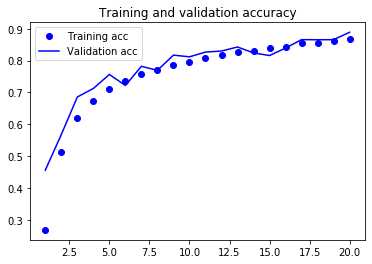

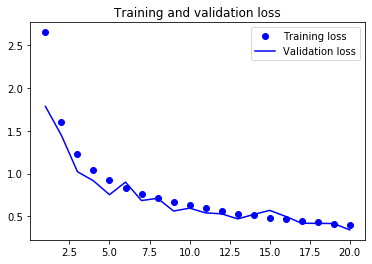

In [7]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Freeze model and save it

- Create new Session and Graph
- Call `tf.contrib.quantize.create_eval_graph` and get graph_def after building model before saver.restore
- Call `saver.restore` to load the trained weights.
   - saver.restore may add unneeded variables to the graph. So we have to get the graph_def before save.restore is called.
- We can use `tf.graph_util.convert_variables_to_constants` to freeze the graph_def

In [9]:
# eval
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
eval_graph = tf.Graph()
eval_sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

keras.backend.set_session(eval_sess)

with eval_graph.as_default():
    keras.backend.set_learning_phase(0)
    eval_model = build_keras_model()
    tf.contrib.quantize.create_eval_graph(input_graph=eval_graph)
    eval_graph_def = eval_graph.as_graph_def()
    saver = tf.train.Saver()
    saver.restore(eval_sess, './checkpoints')

    frozen_graph_def = tf.graph_util.convert_variables_to_constants(
        eval_sess,
        eval_graph_def,
        [eval_model.output.op.name]
    )

    with open('VGG16_frozen_model.pb', 'wb') as f:
        f.write(frozen_graph_def.SerializeToString())

<keras.engine.input_layer.InputLayer object at 0x7efb083c3c18> False
<keras.layers.convolutional.Conv2D object at 0x7efb083c3ac8> False
<keras.layers.convolutional.Conv2D object at 0x7efb084376a0> False
<keras.layers.pooling.MaxPooling2D object at 0x7efb083d2be0> False
<keras.layers.convolutional.Conv2D object at 0x7efb083d27b8> False
<keras.layers.convolutional.Conv2D object at 0x7efb083e2748> False
<keras.layers.pooling.MaxPooling2D object at 0x7efb083a4c88> False
<keras.layers.convolutional.Conv2D object at 0x7efb083a49e8> False
<keras.layers.convolutional.Conv2D object at 0x7efb08356208> False
<keras.layers.convolutional.Conv2D object at 0x7efb0836bda0> False
<keras.layers.pooling.MaxPooling2D object at 0x7efb083205c0> False
<keras.layers.convolutional.Conv2D object at 0x7efb08305dd8> False
<keras.layers.convolutional.Conv2D object at 0x7efb082cf208> False
<keras.layers.convolutional.Conv2D object at 0x7efb082ed390> False
<keras.layers.pooling.MaxPooling2D object at 0x7efb08288c50>